This notebook covers our attempts to build different model combinations to predict average IMDB ratings of movies using plots, year, runtimes, genres and total votes. We hope to evaluate whether there is an improvement of model performance when we include the information of plot. By comparing model that incorporates plot information with the baseline model that only uses year, runtimes, genres and total votes as predictors, we hope to demonstrate that the added information of plotlines increases model accuracy in predicting audience interests. 

In the following code chunks, we conducted sentiment analysis on plot, create a baseline model, generate word embeddings with neural net embedding layer, and experiment with tuning a pretained GloVe embedding.


We begin our model exploration with sentiment analysis with Vader to get a quick taste of the dataset. The polarity, subjectivity, and compound score provide us with the tone and language used in the textual data, which can also be extracted as independent variables for rating prediction. 

In [ ]:
!pip install textblob
!pip install wordcloud
!pip install langdetect

In [ ]:
# import libraries
import pandas as pd
import numpy as np

# Text processing
import re 
from textblob import TextBlob
import string

# Word cloud visualization
from wordcloud import WordCloud, STOPWORDS
from PIL import Image

# Machine learning (sentiment analysis)
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from langdetect import detect
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer

# This one will be used to help us with lexicon
import nltk
nltk.download('vader_lexicon')


# Other visualization
import matplotlib.pyplot as plt
import plotly.express as px

/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


### Data Preparation

In [ ]:
# read in cleaned data 
csv_file = "cleaned.csv"
df = pd.read_csv(csv_file)
df.drop(labels='Unnamed: 0', axis=1, inplace=True)

In [ ]:
# lower the case in the plot data and use regular expressions to remove punctuations
df['plot_lower'] = df["plot"].str.lower()
df['plot_no_punctuation'] = df['plot_lower'].str.replace('[^\w\s]','')
# df['plot_no_stopwords'] = df['plot_no_punctuation'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
df

,originalTitle,plot,startYear,runtimeMinutes,averageRating,numVotes,genres,Drama,Documentary,Action,Animation,Comedy,Biography,Thriller,Crime,Adventure,Sci-Fi,Mystery,Romance,Horror,Fantasy,Family,History,War,Music,Sport,Western,Musical,News,Reality-TV,Game-Show,plot_lower,plot_no_punctuation
0,The Other Side of the Wind,A Hollywood director emerges from semi-exile w...,2018,122,6.9,4981,['Drama'],1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,a hollywood director emerges from semi-exile w...,a hollywood director emerges from semiexile wi...
1,Cooper and Hemingway: The True Gen,Cooper and Hemingway: The True Gen is an unpre...,2013,180,7.6,53,['Documentary'],0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,cooper and hemingway: the true gen is an unpre...,cooper and hemingway the true gen is an unprec...
2,Reverse Heaven,"In 1990s Los Angeles, danger lurks around the ...",2018,104,3.9,74,['Drama'],1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"in 1990s los angeles, danger lurks around the ...",in 1990s los angeles danger lurks around the c...
3,Foodfight!,"When the supermarket closes at night, the cont...",2012,91,1.6,8789,"['Action', 'Animation', 'Comedy']",0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"when the supermarket closes at night, the cont...",when the supermarket closes at night the conte...
4,Return to Babylon,The scandals and decadent lives of the 1920's ...,2013,75,5.8,129,"['Biography', 'Comedy', 'Drama']",1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,the scandals and decadent lives of the 1920's ...,the scandals and decadent lives of the 1920s g...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22352,Falling Inn Love,When city girl Gabriela spontaneously enters a...,2019,98,5.6,9463,"['Comedy', 'Romance']",0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,when city girl gabriela spontaneously enters a...,when city girl gabriela spontaneously enters a...
22353,Chasing Happiness,A behind-the-scenes look at the life and work ...,2019,96,7.9,1398,['Documentary'],0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,a behind-the-scenes look at the life and work ...,a behindthescenes look at the life and work of...
22354,VFW,A group of war veterans must defend their loca...,2019,92,7.2,74,"['Action', 'Horror']",0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,a group of war veterans must defend their loca...,a group of war veterans must defend their loca...
22355,The Pilgrim's Progress,"An epic journey, faithfully adapted to modern-...",2019,108,4.9,252,"['Adventure', 'Animation', 'Family']",0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,"an epic journey, faithfully adapted to modern-...",an epic journey faithfully adapted to modernda...


Although our target variable average rating is a numeric feature, the values can only be within the range of 1 - 10. Therefore,  it would be more appropriate to convert the rating for a movie into a categorical variable to avoid impossible prediction (eg. model predict rating larger than 10 or smaller than 1).

In [ ]:
np.min(df.averageRating), np.max(df.averageRating)

(1.0, 10.0)

In [ ]:
df['averageRating_class'] = df['averageRating'].apply(lambda x: 0 if x <5 else (2 if x >= 7 else 1))
np.unique(df['averageRating_class']) #feature engineering- turn target variable average rating into 3 classes

array([0, 1, 2])

In [ ]:
df[['averageRating_class', 'averageRating']]

,averageRating_class,averageRating
0,1,6.9
1,2,7.6
2,0,3.9
3,0,1.6
4,1,5.8
...,...,...
22352,1,5.6
22353,2,7.9
22354,2,7.2
22355,0,4.9


### Sentiment Analysis

In [ ]:
#positive sentiment : (compound score >= 0.05)
#neutral sentiment : (compound score > -0.05) and (compound score < 0.05)
#negative sentiment : (compound score <= -0.05)
df[['polarity','subjectivity']] = df['plot_no_punctuation'].apply(lambda Text : pd.Series(TextBlob(Text).sentiment))

Here, the polarity score indicate positive/negative opinions in the plot description of a movie, and the subjectivity showcases the factual tone of the text.

In [ ]:
# Computing a score for the text column using SentimentIntensityAnalyzer 
for index,row in df['plot_no_punctuation'].iteritems():
    # compute a score
    score = SentimentIntensityAnalyzer().polarity_scores(row)

    # Assign score categories to variables
    neg = score['neg']
    neu = score['neu']
    pos = score['pos']
    comp = score['compound']
    
    # If negative score (neg) is greater than positive score (pos), then the text should be categorized as "negative"
    if neg> pos:
        df.loc[index,"sentiment"] = 'negative'
    # If positive score (pos) is greater than the negative score (neg), then the text should be categorized as "positive"
    elif pos > neg:
        df.loc[index,"sentiment"] = "positive"
    # Otherwise 
    else:
        df.loc[index,"sentiment"] = "neutral"
    df.loc[index,'neg'] = neg
    df.loc[index,'pos'] = pos
    df.loc[index,'neu'] = neu
    df.loc[index,'compound'] = comp

In [ ]:
# check the unique sentiment types
df['sentiment'].unique()

array(['positive', 'negative', 'neutral'], dtype=object)

In [ ]:
df.tail(10)

,originalTitle,plot,startYear,runtimeMinutes,averageRating,numVotes,genres,Drama,Documentary,Action,Animation,Comedy,Biography,Thriller,Crime,Adventure,Sci-Fi,Mystery,Romance,Horror,Fantasy,Family,History,War,Music,Sport,Western,Musical,News,Reality-TV,Game-Show,plot_lower,plot_no_punctuation,averageRating_class,polarity,subjectivity,sentiment,neg,pos,neu,compound
22347,The Banana Splits Movie,A boy named Harley and his family (brother Aus...,2019,89,5.0,1644,"['Comedy', 'Horror', 'Sci-Fi']",0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,a boy named harley and his family (brother aus...,a boy named harley and his family brother aust...,1,0.100000,0.400000,neutral,0.000,0.000,1.000,0.0000
22348,Love Struck Sick,This movie is all about one of the greatest Yo...,2019,92,7.0,283,['Romance'],0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,this movie is all about one of the greatest yo...,this movie is all about one of the greatest yo...,2,0.700000,1.000000,positive,0.000,0.195,0.805,0.7430
22349,Out of Liberty,"Winter 1839. LIBERTY, MISSOURI. Local jailer, ...",2019,111,8.2,84,"['Drama', 'Western']",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,"winter 1839. liberty, missouri. local jailer, ...",winter 1839 liberty missouri local jailer samu...,2,0.166667,0.166667,positive,0.000,0.156,0.844,0.5859
22350,Fin de siglo,Two men meet in Barcelona and after spending a...,2019,84,7.2,212,['Drama'],1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,two men meet in barcelona and after spending a...,two men meet in barcelona and after spending a...,2,0.000000,0.000000,neutral,0.000,0.000,1.000,0.0000
22351,Kaijû no kodomo,A young girl is drawn into a mystery involving...,2019,110,6.6,311,"['Adventure', 'Animation', 'Fantasy']",0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,a young girl is drawn into a mystery involving...,a young girl is drawn into a mystery involving...,1,0.050000,0.700000,neutral,0.000,0.000,1.000,0.0000
22352,Falling Inn Love,When city girl Gabriela spontaneously enters a...,2019,98,5.6,9463,"['Comedy', 'Romance']",0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,when city girl gabriela spontaneously enters a...,when city girl gabriela spontaneously enters a...,1,0.345455,0.518182,positive,0.000,0.129,0.871,0.5719
22353,Chasing Happiness,A behind-the-scenes look at the life and work ...,2019,96,7.9,1398,['Documentary'],0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,a behind-the-scenes look at the life and work ...,a behindthescenes look at the life and work of...,2,0.250000,0.333333,neutral,0.000,0.000,1.000,0.0000
22354,VFW,A group of war veterans must defend their loca...,2019,92,7.2,74,"['Action', 'Horror']",0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,a group of war veterans must defend their loca...,a group of war veterans must defend their loca...,2,0.166667,0.233333,negative,0.132,0.122,0.746,-0.3182
22355,The Pilgrim's Progress,"An epic journey, faithfully adapted to modern-...",2019,108,4.9,252,"['Adventure', 'Animation', 'Family']",0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,"an epic journey, faithfully adapted to modern-...",an epic journey faithfully adapted to modernda...,0,-0.050000,0.287500,positive,0.036,0.164,0.800,0.6428
22356,Manoharam,Manoharan is a poster artist struggling to fin...,2019,122,7.6,56,"['Comedy', 'Drama']",1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,manoharan is a poster artist struggling to fin...,manoharan is a poster artist struggling to fin...,2,-0.195833,0.470833,positive,0.104,0.156,0.741,0.4767


With sentiment information from the movie plots on hands, we are able to manipulate them into our prediction models.

### Data visualization
In this section we want to understand the polarity, subjectivity, and sentiment of the plots in our sample in a visual format.

In [ ]:
# Check the composition of label positive, negative or neutral
list_negative = df[df['sentiment']=='negative']
list_positive = df[df['sentiment']=='positive']
list_neutral = df[df['sentiment']=='neutral']

def count_values_in_column(data,feature):
    
    total = data.loc[:,feature].value_counts(dropna=False)
    percentage = round(data.loc[:,feature].value_counts(dropna=False,normalize=True)*100,2)
    
    return pd.concat([total,percentage],axis=1, keys=['Total', 'Percentage'])

# Values for sentiment
pc = count_values_in_column(df, "sentiment")

pc

,Total,Percentage
negative,10902,48.76
positive,9992,44.69
neutral,1463,6.54


We can see the data is polarized in the sentiment, while there are similar numbers in positive and negative texts, which is balanced.

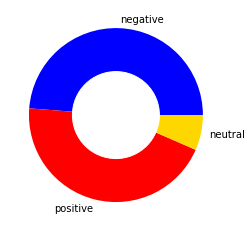

In [ ]:
# Create a piechart
names = pc.index
size = pc['Percentage']
my_circle = plt.Circle((0,0), 0.5, color='white')
plt.pie(size, labels=names,colors=['blue','red','gold'])
p = plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

In [ ]:
# Function to Create Wordcloud
def create_wordcloud(text):
    mask = np.array(Image.open("cloud.jpeg"))
    stopwords = set(STOPWORDS)
    wc = WordCloud(background_color="white",
    mask = mask,
    max_words=3000,
    stopwords=stopwords,
    repeat=True)
    wc.generate(str(text))
    wc.to_file("wc.png")
    # print("Word Cloud Saved Successfully")
    path="wc.png"
    display(Image.open(path))

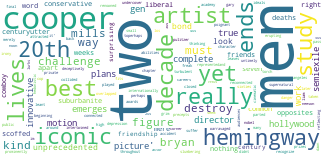

In [ ]:
#Creating wordcloud for all plot
create_wordcloud(df['plot_no_punctuation'].values)

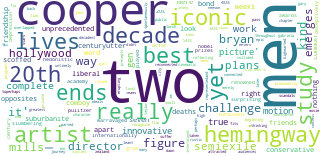

In [ ]:
#Creating wordcloud for positive sentiment
create_wordcloud(list_positive['plot_no_punctuation'].values)

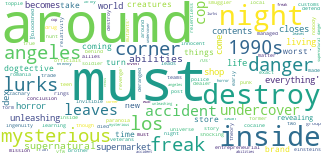

In [ ]:
#Creating wordcloud for negative sentiment
create_wordcloud(list_negative['plot_no_punctuation'].values)

In [ ]:
#Calculating plot’s length and word count
df['text_len'] = df['plot_no_punctuation'].astype(str).apply(len)
df['text_word_count'] = df['plot_no_punctuation'].apply(lambda x: len(str(x).split()))
round(pd.DataFrame(df.groupby("sentiment").text_len.mean()),2)

,text_len
sentiment,
negative,367.92
neutral,143.77
positive,409.00


In [ ]:
round(pd.DataFrame(df.groupby("sentiment").text_word_count.mean()),2)

,text_word_count
sentiment,
negative,64.09
neutral,24.76
positive,70.83


There seems no huge difference between text length and word counts in positive and negative expressions, which again showcases the balance of the dataset. As to neutral plots, they seem to be shorter in both text length and word counts.  
We then further wrangle the plots for nautural language processing.

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
#Removing Punctuation
# def remove_punct(text):
#     text = "".join([char for char in text if char not in string.punctuation])
#     text = re.sub('[0–9]+', '', text)
#     return text
# df['punct'] = twitter_data['text'].apply(lambda x: remove_punct(x))

#Applying tokenization
def tokenization(text):
    text = re.split('\W+', text)
    return text
df['tokenized'] = df['plot_no_punctuation'].apply(lambda x: tokenization(x.lower()))


#Removing stopwords
stopword = nltk.corpus.stopwords.words('english')
def remove_stopwords(text):
    text = [word for word in text if word not in stopword]
    return text
    
df['nonstop'] = df['tokenized'].apply(lambda x: remove_stopwords(x))

#Applying Stemmer
ps = nltk.PorterStemmer()
def stemming(text):
    text = [ps.stem(word) for word in text]
    return text
df['stemmed'] = df['nonstop'].apply(lambda x: stemming(x))

#Cleaning Text
def clean_text(text):
    text_lc = "".join([word.lower() for word in text if word not in string.punctuation]) # remove puntuation
    text_rc = re.sub('[0-9]+', '', text_lc)
    tokens = re.split('\W+', text_rc)    # tokenization
    text = [ps.stem(word) for word in tokens if word not in stopword]  # remove stopwords and stemming
    return text
df.head()

,originalTitle,plot,startYear,runtimeMinutes,averageRating,numVotes,genres,Drama,Documentary,Action,Animation,Comedy,Biography,Thriller,Crime,Adventure,Sci-Fi,Mystery,Romance,Horror,Fantasy,Family,History,War,Music,Sport,Western,Musical,News,Reality-TV,Game-Show,plot_lower,plot_no_punctuation,averageRating_class,polarity,subjectivity,sentiment,neg,pos,neu,compound,text_len,text_word_count,Year_2010,Year_2011,Year_2012,Year_2013,Year_2014,Year_2015,Year_2016,Year_2017,Year_2018,Year_2019,nonstop_str,tokenized,nonstop,stemmed
0,The Other Side of the Wind,A Hollywood director emerges from semi-exile w...,2018,122,6.9,4981,['Drama'],1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,a hollywood director emerges from semi-exile w...,a hollywood director emerges from semiexile wi...,1,0.300000,0.700000,positive,0.000,0.172,0.828,0.4404,103,16,0,0,0,0,0,0,0,0,1,0,hollywood director emerges semiexile plans com...,"[a, hollywood, director, emerges, from, semiex...","[hollywood, director, emerges, semiexile, plan...","[hollywood, director, emerg, semiexil, plan, c..."
1,Cooper and Hemingway: The True Gen,Cooper and Hemingway: The True Gen is an unpre...,2013,180,7.6,53,['Documentary'],0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,cooper and hemingway: the true gen is an unpre...,cooper and hemingway the true gen is an unprec...,2,0.188845,0.435070,positive,0.065,0.134,0.801,0.9600,1505,258,0,0,0,1,0,0,0,0,0,0,cooper hemingway true gen unprecedented look b...,"[cooper, and, hemingway, the, true, gen, is, a...","[cooper, hemingway, true, gen, unprecedented, ...","[cooper, hemingway, true, gen, unpreced, look,..."
2,Reverse Heaven,"In 1990s Los Angeles, danger lurks around the ...",2018,104,3.9,74,['Drama'],1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"in 1990s los angeles, danger lurks around the ...",in 1990s los angeles danger lurks around the c...,0,-0.016667,0.283333,negative,0.469,0.042,0.488,-0.9643,209,33,0,0,0,0,0,0,0,0,1,0,1990s los angeles danger lurks around corner f...,"[in, 1990s, los, angeles, danger, lurks, aroun...","[1990s, los, angeles, danger, lurks, around, c...","[1990, lo, angel, danger, lurk, around, corner..."
3,Foodfight!,"When the supermarket closes at night, the cont...",2012,91,1.6,8789,"['Action', 'Animation', 'Comedy']",0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"when the supermarket closes at night, the cont...",when the supermarket closes at night the conte...,0,-0.329545,0.609848,negative,0.087,0.000,0.913,-0.6249,252,47,0,0,1,0,0,0,0,0,0,0,supermarket closes night contents inside come ...,"[when, the, supermarket, closes, at, night, th...","[supermarket, closes, night, contents, inside,...","[supermarket, close, night, content, insid, co..."
4,Return to Babylon,The scandals and decadent lives of the 1920's ...,2013,75,5.8,129,"['Biography', 'Comedy', 'Drama']",1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,the scandals and decadent lives of the 1920's ...,the scandals and decadent lives of the 1920s g...,1,1.000000,1.000000,positive,0.195,0.256,0.549,0.2500,65,11,0,0,0,1,0,0,0,0,0,0,scandals decadent lives 1920s greatest movie s...,"[the, scandals, and, decadent, lives, of, the,...","[scandals, decadent, lives, 1920s, greatest, m...","[scandal, decad, live, 1920, greatest, movi, s..."


In [ ]:
#Applying Countvectorizer
countVectorizer = CountVectorizer(analyzer=clean_text) 
countVector = countVectorizer.fit_transform(df['plot_no_punctuation'])
print('{} Number of plots has {} words'.format(countVector.shape[0], countVector.shape[1]))
#print(countVectorizer.get_feature_names())

count_vect_df = pd.DataFrame(countVector.toarray(), columns=countVectorizer.get_feature_names())

22357 Number of plots has 39675 words


In [ ]:
# Most Used Words
count = pd.DataFrame(count_vect_df.sum(),columns=["Value"])
countdf = count.sort_values("Value",ascending=False).head(20)

px.bar(countdf[1:],x=countdf.index[1:],y="Value")

In the most used words, we can have a glance of the common tone of movie plots. Recall that the word "two" reprents positivity seems not very intuitive, we can remove it and see how the data reacts.

In [ ]:
#lambda function to remove "two"
remove_pb = lambda x: re.sub("two","",x)

df['plot_no_punctuation'] = df['plot_no_punctuation'].map(remove_pb)

In [ ]:
#reclassify

#Computing a score using sentiment analyzer

for index,row in df['plot_no_punctuation'].iteritems():
    #compute a score
    score = SentimentIntensityAnalyzer().polarity_scores(row)
    
    #Assign score categories to variables
    neg = score['neg']
    neu = score['neu']
    pos = score['pos']
    comp = score ['compound']
    
    #if negative score(neg) is greater than positive score (pos), then the text should be "negative"
    
    if neg > pos:
        df.loc[index,"sentiment"] = 'negative'
    elif pos > neg:
        df.loc[index,"sentiment"] = 'positive'
    else:
        df.loc[index,"sentiment"] = "neutral"
    df.loc[index,'neg'] = neg
    df.loc[index,'pos'] = pos
    df.loc[index,'neu'] = neu
    df.loc[index,'compound'] = comp

In [ ]:
df.tail(10)

,originalTitle,plot,startYear,runtimeMinutes,averageRating,numVotes,genres,Drama,Documentary,Action,Animation,Comedy,Biography,Thriller,Crime,Adventure,Sci-Fi,Mystery,Romance,Horror,Fantasy,Family,History,War,Music,Sport,Western,Musical,News,Reality-TV,Game-Show,plot_lower,plot_no_punctuation,averageRating_class,polarity,subjectivity,sentiment,neg,pos,neu,compound,text_len,text_word_count,tokenized,nonstop,stemmed
22347,The Banana Splits Movie,A boy named Harley and his family (brother Aus...,2019,89,5.0,1644,"['Comedy', 'Horror', 'Sci-Fi']",0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,a boy named harley and his family (brother aus...,a boy named harley and his family brother aust...,1,0.100000,0.400000,neutral,0.000,0.000,1.000,0.0000,179,33,"[a, boy, named, harley, and, his, family, brot...","[boy, named, harley, family, brother, austin, ...","[boy, name, harley, famili, brother, austin, m..."
22348,Love Struck Sick,This movie is all about one of the greatest Yo...,2019,92,7.0,283,['Romance'],0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,this movie is all about one of the greatest yo...,this movie is all about one of the greatest yo...,2,0.700000,1.000000,positive,0.000,0.195,0.805,0.7430,142,29,"[this, movie, is, all, about, one, of, the, gr...","[movie, one, greatest, youtubers, time, aliena...","[movi, one, greatest, youtub, time, alienameri..."
22349,Out of Liberty,"Winter 1839. LIBERTY, MISSOURI. Local jailer, ...",2019,111,8.2,84,"['Drama', 'Western']",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,"winter 1839. liberty, missouri. local jailer, ...",winter 1839 liberty missouri local jailer samu...,2,0.166667,0.166667,positive,0.000,0.156,0.844,0.5859,180,28,"[winter, 1839, liberty, missouri, local, jaile...","[winter, 1839, liberty, missouri, local, jaile...","[winter, 1839, liberti, missouri, local, jaile..."
22350,Fin de siglo,Two men meet in Barcelona and after spending a...,2019,84,7.2,212,['Drama'],1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,two men meet in barcelona and after spending a...,men meet in barcelona and after spending a da...,2,0.000000,0.000000,neutral,0.000,0.000,1.000,0.0000,116,21,"[two, men, meet, in, barcelona, and, after, sp...","[two, men, meet, barcelona, spending, day, tog...","[two, men, meet, barcelona, spend, day, togeth..."
22351,Kaijû no kodomo,A young girl is drawn into a mystery involving...,2019,110,6.6,311,"['Adventure', 'Animation', 'Fantasy']",0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,a young girl is drawn into a mystery involving...,a young girl is drawn into a mystery involving...,1,0.050000,0.700000,neutral,0.000,0.000,1.000,0.0000,121,21,"[a, young, girl, is, drawn, into, a, mystery, ...","[young, girl, drawn, mystery, involving, seali...","[young, girl, drawn, mysteri, involv, sealif, ..."
22352,Falling Inn Love,When city girl Gabriela spontaneously enters a...,2019,98,5.6,9463,"['Comedy', 'Romance']",0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,when city girl gabriela spontaneously enters a...,when city girl gabriela spontaneously enters a...,1,0.345455,0.518182,positive,0.000,0.129,0.871,0.5719,159,28,"[when, city, girl, gabriela, spontaneously, en...","[city, girl, gabriela, spontaneously, enters, ...","[citi, girl, gabriela, spontan, enter, contest..."
22353,Chasing Happiness,A behind-the-scenes look at the life and work ...,2019,96,7.9,1398,['Documentary'],0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,a behind-the-scenes look at the life and work ...,a behindthescenes look at the life and work of...,2,0.250000,0.333333,neutral,0.000,0.000,1.000,0.0000,112,21,"[a, behindthescenes, look, at, the, life, and,...","[behindthescenes, look, life, work, jonas, bro...","[behindthescen, look, life, work, jona, brothe..."
22354,VFW,A group of war veterans must defend their loca...,2019,92,7.2,74,"['Action', 'Horror']",0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,a group of war veterans must defend their loca...,a group of war veterans must defend their loca

In [ ]:
#visualize again

#let's take a look at how many are labelelled positive, negative or neutral

tw_list_negative = df[df['sentiment']=='negative']

tw_list_positive = df[df['sentiment']=='positive']

tw_list_neutral = df[df['sentiment']=='neutral']

#count how many values belong to each category (how many tweets are positive, negative, neutral)

def count_values_in_column(data,feature):
    total = data.loc[:,feature].value_counts(dropna=False)
    percentage = round(data.loc[:,feature].value_counts(dropna=False, normalize=True)*100,2)
    
    return pd.concat([total,percentage],axis=1,keys=['Total','Percentage'])

pc = count_values_in_column(df, "sentiment")

pc

,Total,Percentage
negative,10900,48.75
positive,9990,44.68
neutral,1467,6.56


It seems including the word "two" or not does not change the results much, so we can still keep it.

In [ ]:
# one hot-encode year
y = pd.get_dummies(df.startYear, prefix='Year')
df = pd.concat([df, y], axis = 1)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22357 entries, 0 to 22356
Data columns (total 56 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   originalTitle        22357 non-null  object 
 1   plot                 22357 non-null  object 
 2   startYear            22357 non-null  int64  
 3   runtimeMinutes       22357 non-null  int64  
 4   averageRating        22357 non-null  float64
 5   numVotes             22357 non-null  int64  
 6   genres               22357 non-null  object 
 7   Drama                22357 non-null  int64  
 8   Documentary          22357 non-null  int64  
 9   Action               22357 non-null  int64  
 10  Animation            22357 non-null  int64  
 11  Comedy               22357 non-null  int64  
 12  Biography            22357 non-null  int64  
 13  Thriller             22357 non-null  int64  
 14  Crime                22357 non-null  int64  
 15  Adventure            22357 non-null 

In [ ]:
import seaborn as sns


# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [ ]:
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

print(tf.__version__)

2.5.0


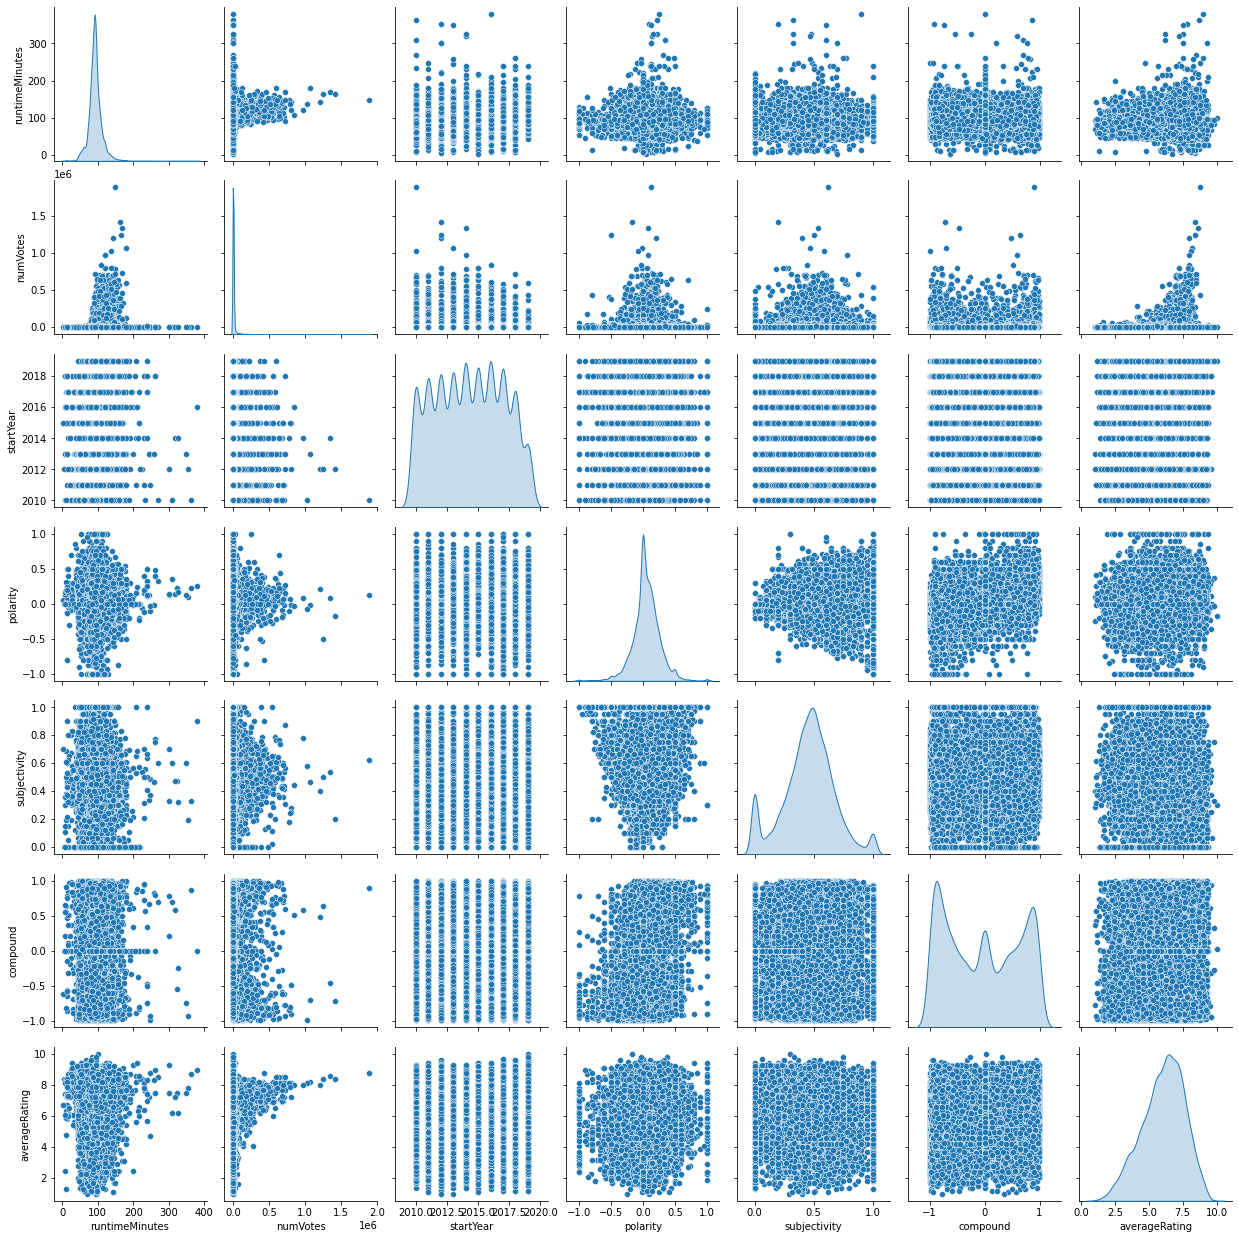

In [ ]:
# examine variables' relationships with pairplot
# genre is not included since it is an object variable
sns.pairplot(df[['runtimeMinutes', 'numVotes', 'startYear', 'polarity', 'subjectivity', 'compound', 'averageRating']], diag_kind='kde');

We can observe several trends in the pairplot. First, the runtime is evenly distributed over the ratings, while long movies have the tendency to recieve high ratings. Second, higher rated movies tend to have more votes. The ratings slightly skew to the right side, while overall they are still normally distributed. Finally, other features seem to be evenly located over the ratings.

In [ ]:
!pip install dython
import dython.nominal

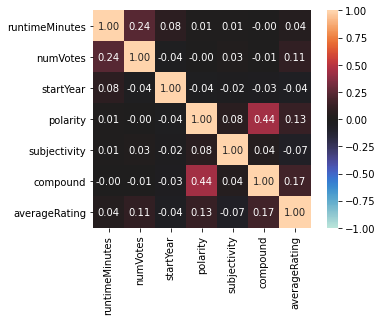

In [ ]:
# check the correlation
assoc = dython.nominal.associations(df[['runtimeMinutes', 'numVotes', 'startYear', 'polarity', 'subjectivity', 'compound', 'averageRating']], plot=False)
corr = assoc['corr']

Only *number of votes* have weak relationship with *averageRating*. We can expect the model prediction power will not be too significant.

### Build models

In this code chunk, we first create two baseline models, linear and neural networks, for prediction of the movie ratings. These models only include *runtime, genre, year, number of votes*.

In [ ]:
# split dataset
train_dataset = df.sample(frac=0.8, random_state=0)
test_dataset = df.drop(train_dataset.index)

In [ ]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
startYear,17886.0,2014.286257,2.677110,2010.0000,2012.000000,2014.000000,2017.000000,2.019000e+03
runtimeMinutes,17886.0,92.136475,19.358735,3.0000,83.000000,91.000000,100.000000,3.790000e+02
averageRating,17886.0,6.039070,1.549262,1.0000,5.000000,6.200000,7.200000,9.800000e+00
numVotes,17886.0,10356.581013,54150.585378,10.0000,32.000000,137.000000,952.750000,1.419530e+06
Drama,17886.0,0.401040,0.490123,0.0000,0.000000,0.000000,1.000000,1.000000e+00
Documentary,17886.0,0.218159,0.413008,0.0000,0.000000,0.000000,0.000000,1.000000e+00
Action,17886.0,0.123952,0.329536,0.0000,0.000000,0.000000,0.000000,1.000000e+00
Animation,17886.0,0.026669,0.161118,0.0000,0.000000,0.000000,0.000000,1.000000e+00
Comedy,17886.0,0.247512,0.431579,0.0000,0.000000,0.000000,0.000000,1.000000e+00
Biography,17886.0,0.060438,0.238304,0.0000,0.000000,0.000000,0.000000,1.000000e+00


In [ ]:
train_features = train_dataset[train_dataset.columns.difference(['averageRating','originalTitle', 'startYear', 'plot', 'genres', 'polarity', 'subjectivity', 'neg', 'pos', 'neu', 'compound', 'text_len', 'text_word_count','nonstop','plot_lower','plot_no_punctuation','sentiment','stemmed','tokenized',])].copy()
test_features = test_dataset[test_dataset.columns.difference(['averageRating','originalTitle', 'startYear', 'plot', 'genres', 'polarity', 'subjectivity', 'neg', 'pos', 'neu', 'compound', 'text_len', 'text_word_count','nonstop','plot_lower','plot_no_punctuation','sentiment','stemmed','tokenized'])].copy()

train_labels = train_features.pop('averageRating_class')
test_labels = test_features.pop('averageRating_class')

In [ ]:
train_features

,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,Game-Show,History,Horror,Music,Musical,Mystery,News,Reality-TV,Romance,Sci-Fi,Sport,Thriller,War,Western,Year_2010,Year_2011,Year_2012,Year_2013,Year_2014,Year_2015,Year_2016,Year_2017,Year_2018,Year_2019,numVotes,runtimeMinutes
4840,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,265,95
19354,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,5043,98
15252,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,3990,79
4037,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,21,78
6686,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,17,89
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17549,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,323,90
1192,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,2979,87
14613,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1054,90
3690,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,14,85


In [ ]:
# we have 36 input features
normalizer = preprocessing.Normalization(input_shape=[36,])
normalizer.adapt(np.array(train_features))

In [ ]:
linear_model = tf.keras.Sequential([
    normalizer,
    tf.keras.layers.Dense(3, activation=tf.nn.softmax)
])

linear_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 36)                73        
_________________________________________________________________
dense (Dense)                (None, 3)                 111       
Total params: 184
Trainable params: 111
Non-trainable params: 73
_________________________________________________________________


In [ ]:
linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='categorical_crossentropy',
    metrics=['accuracy'])

In [ ]:
train_labels

4840     2
19354    1
15252    2
4037     2
6686     0
        ..
17549    2
1192     0
14613    0
3690     2
12877    1
Name: averageRating_class, Length: 17886, dtype: int64

In [ ]:
train_labels = train_labels.values
encoder = LabelEncoder()
encoder.fit(train_labels)
train_labels = encoder.transform(train_labels)
train_labels = tf.keras.utils.to_categorical(
    train_labels,
    num_classes=3
)

test_labels = test_labels.values
encoder = LabelEncoder()
encoder.fit(test_labels)
test_labels = encoder.transform(test_labels)
test_labels = tf.keras.utils.to_categorical(
    test_labels,
    num_classes=3
)

In [ ]:
# create early stopping
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=8)
history = linear_model.fit(
    train_features, train_labels,
    epochs=1000, batch_size= 128,
    callbacks=[callback],
    # suppress logging
#     verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,accuracy,val_loss,val_accuracy,epoch
5,0.996297,0.534037,1.018080,0.487703,5
6,0.971969,0.544031,0.986894,0.544718,6
7,1.006035,0.537951,0.985600,0.550028,7
8,0.980163,0.539558,0.960071,0.541923,8
9,0.975196,0.543682,0.971540,0.548072,9


In [ ]:
def plot_loss(history, ylim=10):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, ylim])
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)

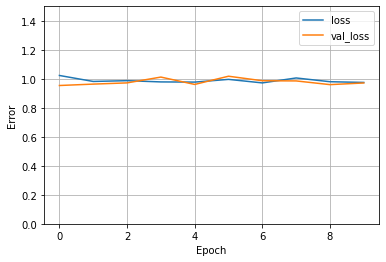

In [ ]:
plot_loss(history, 1.5)

In [ ]:
test_results = {}

test_results['linear_model'] = linear_model.evaluate(
    test_features,
    test_labels, verbose=0)

Here we see that a linear neural network model does not perform well on training or testing set. It converged at the first several epochs and could not catch enough information that is related to our prediction target. We then introduce nonlinearity into the neural network model.

In [ ]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(32, activation='relu'),
      layers.Dense(3, activation='softmax')
  ])

  model.compile(loss='categorical_crossentropy',
                metrics=['accuracy'],
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [ ]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 36)                73        
_________________________________________________________________
dense_1 (Dense)              (None, 64)                2368      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 99        
Total params: 4,620
Trainable params: 4,547
Non-trainable params: 73
_________________________________________________________________


In [ ]:
history = dnn_model.fit(
    train_features, train_labels, batch_size=128,
    validation_split=0.2, epochs=1000, callbacks=[callback])

Epoch 1/1000
112/112 [==============================] - 1s 5ms/step - loss: 0.9915 - accuracy: 0.5109 - val_loss: 0.8967 - val_accuracy: 0.5769
Epoch 2/1000
112/112 [==============================] - 0s 3ms/step - loss: 0.8949 - accuracy: 0.5764 - val_loss: 0.8754 - val_accuracy: 0.5897
Epoch 3/1000
112/112 [==============================] - 0s 3ms/step - loss: 0.8784 - accuracy: 0.5861 - val_loss: 0.8712 - val_accuracy: 0.5931
Epoch 4/1000
112/112 [==============================] - 0s 3ms/step - loss: 0.8680 - accuracy: 0.5933 - val_loss: 0.8668 - val_accuracy: 0.5897
Epoch 5/1000
112/112 [==============================] - 0s 3ms/step - loss: 0.8614 - accuracy: 0.5955 - val_loss: 0.8606 - val_accuracy: 0.5925
Epoch 6/1000
112/112 [==============================] - 0s 3ms/step - loss: 0.8556 - accuracy: 0.5996 - val_loss: 0.8579 - val_accuracy: 0.5978
Epoch 7/1000
112/112 [==============================] - 0s 3ms/step - loss: 0.8501 - accuracy: 0.6029 - val_loss: 0.8604 - val_accuracy:

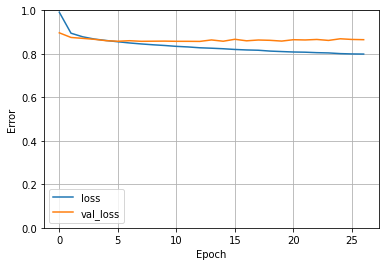

In [ ]:
plot_loss(history, 1)

In [ ]:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

In [ ]:
pd.DataFrame(test_results, index=['Categorical Crossentropy', 'Accuracy']).T

,Categorical Crossentropy,Accuracy
linear_model,0.990827,0.541713
dnn_model,0.897526,0.587117


We can see two models have around 50% prediction accuracy without textual information, and we would like to examine their performance when feeding plot information into the models.

#### Incorporating Sentiment Information

In [ ]:
train_features = train_dataset[train_dataset.columns.difference(['averageRating','originalTitle', 'startYear', 'plot', 'genres','nonstop','plot_lower','plot_no_punctuation','sentiment','stemmed','tokenized'])].copy()
test_features = test_dataset[test_dataset.columns.difference(['averageRating','originalTitle', 'startYear', 'plot', 'genres','nonstop','plot_lower','plot_no_punctuation','sentiment','stemmed','tokenized'])].copy()

train_labels = train_features.pop('averageRating_class')
test_labels = test_features.pop('averageRating_class')

In [ ]:
train_features

,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,Game-Show,History,Horror,Music,Musical,Mystery,News,Reality-TV,Romance,Sci-Fi,Sport,Thriller,War,Western,Year_2010,Year_2011,Year_2012,Year_2013,Year_2014,Year_2015,Year_2016,Year_2017,Year_2018,Year_2019,compound,neg,neu,numVotes,polarity,pos,runtimeMinutes,subjectivity,text_len,text_word_count
4840,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0.5994,0.082,0.795,265,0.143750,0.123,95,0.394792,503,85
19354,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,-0.4019,0.188,0.717,5043,-0.050000,0.096,98,0.200000,153,27
15252,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0.9872,0.033,0.703,3990,0.309366,0.265,79,0.570110,779,129
4037,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0.5273,0.080,0.777,21,0.250000,0.142,78,0.625000,555,92
6686,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,-0.4605,0.144,0.711,17,0.168750,0.144,89,0.400000,411,82
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17549,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.0000,0.000,1.000,323,0.000000,0.000,90,0.000000,73,12
1192,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,-0.8479,0.172,0.828,2979,0.025000,0.000,87,0.791667,355,60
14613,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,-0.2960,0.064,0.936,1054,0.035795,0.000,90,0.456818,184,35
3690,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,-0.9774,0.158,0.773,14,0.052273,0.068,85,0.437720,1866,316


In [ ]:
# we have 44 input features now
normalizer = preprocessing.Normalization(input_shape=[44,])
normalizer.adapt(np.array(train_features))

In [ ]:
linear_model = tf.keras.Sequential([
    normalizer,
    tf.keras.layers.Dense(3, activation=tf.nn.softmax)
])

linear_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 44)                89        
_________________________________________________________________
dense (Dense)                (None, 3)                 135       
Total params: 224
Trainable params: 135
Non-trainable params: 89
_________________________________________________________________


In [ ]:
linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='categorical_crossentropy',
    metrics=['accuracy'])

In [ ]:
train_labels = train_labels.values
encoder = LabelEncoder()
encoder.fit(train_labels)
train_labels = encoder.transform(train_labels)
train_labels = tf.keras.utils.to_categorical(
    train_labels,
    num_classes=3
)

test_labels = test_labels.values
encoder = LabelEncoder()
encoder.fit(test_labels)
test_labels = encoder.transform(test_labels)
test_labels = tf.keras.utils.to_categorical(
    test_labels,
    num_classes=3
)

In [ ]:
history = linear_model.fit(
    train_features, train_labels,
    epochs=1000, batch_size= 128,
    callbacks=[callback],
    validation_split = 0.2)

Epoch 1/1000
112/112 [==============================] - 1s 4ms/step - loss: 1.0568 - accuracy: 0.5274 - val_loss: 0.9969 - val_accuracy: 0.5184
Epoch 2/1000
112/112 [==============================] - 0s 2ms/step - loss: 1.0167 - accuracy: 0.5299 - val_loss: 0.9972 - val_accuracy: 0.5344
Epoch 3/1000
112/112 [==============================] - 0s 2ms/step - loss: 1.0150 - accuracy: 0.5295 - val_loss: 1.0230 - val_accuracy: 0.5347
Epoch 4/1000
112/112 [==============================] - 0s 2ms/step - loss: 1.0165 - accuracy: 0.5317 - val_loss: 1.0023 - val_accuracy: 0.5422
Epoch 5/1000
112/112 [==============================] - 0s 2ms/step - loss: 1.0169 - accuracy: 0.5312 - val_loss: 1.0001 - val_accuracy: 0.5347
Epoch 6/1000
112/112 [==============================] - 0s 2ms/step - loss: 1.0103 - accuracy: 0.5310 - val_loss: 0.9973 - val_accuracy: 0.5263
Epoch 7/1000
112/112 [==============================] - 0s 2ms/step - loss: 1.0062 - accuracy: 0.5331 - val_loss: 0.9924 - val_accuracy:

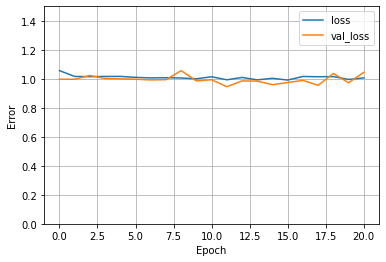

In [ ]:
plot_loss(history, 1.5)

In [ ]:
test_results = {}

test_results['linear_model'] = linear_model.evaluate(
    test_features,
    test_labels, verbose=0)

Here we see that a linear neural network model does not perform well on training or testing set. It converged at the first several epochs and could not catch enough information that is related to our prediction target. We then will introduce nonlinearity into the neural network model.

In [ ]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 44)                89        
_________________________________________________________________
dense_1 (Dense)              (None, 64)                2880      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 99        
Total params: 5,148
Trainable params: 5,059
Non-trainable params: 89
_________________________________________________________________


In [ ]:
history = dnn_model.fit(
    train_features, train_labels, batch_size=128,
    validation_split=0.2, epochs=1000, callbacks=[callback])

Epoch 1/1000
112/112 [==============================] - 1s 4ms/step - loss: 0.9769 - accuracy: 0.5103 - val_loss: 0.8993 - val_accuracy: 0.5743
Epoch 2/1000
112/112 [==============================] - 0s 2ms/step - loss: 0.8942 - accuracy: 0.5742 - val_loss: 0.8859 - val_accuracy: 0.5861
Epoch 3/1000
112/112 [==============================] - 0s 2ms/step - loss: 0.8792 - accuracy: 0.5853 - val_loss: 0.8806 - val_accuracy: 0.5852
Epoch 4/1000
112/112 [==============================] - 0s 2ms/step - loss: 0.8694 - accuracy: 0.5895 - val_loss: 0.8792 - val_accuracy: 0.5869
Epoch 5/1000
112/112 [==============================] - 0s 2ms/step - loss: 0.8606 - accuracy: 0.5948 - val_loss: 0.8768 - val_accuracy: 0.5917
Epoch 6/1000
112/112 [==============================] - 0s 3ms/step - loss: 0.8548 - accuracy: 0.5979 - val_loss: 0.8727 - val_accuracy: 0.5900
Epoch 7/1000
112/112 [==============================] - 0s 2ms/step - loss: 0.8499 - accuracy: 0.6024 - val_loss: 0.8703 - val_accuracy:

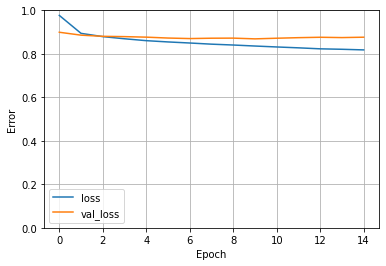

In [ ]:
plot_loss(history, 1)

In [ ]:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

In [ ]:
pd.DataFrame(test_results, index=['Categorical Crossentropy', 'Accuracy']).T

,Categorical Crossentropy,Accuracy
linear_model,1.037703,0.542608
dnn_model,0.895483,0.586670


As expected from the pairplot, incorporating sentiment informaion does not really improve the prediction model. We then move on word embedding to extract more information.

### Word Embedding

In [ ]:
pip install -U mittens

Requirement already up-to-date: mittens in /usr/local/lib/python3.7/dist-packages (0.2)


In [ ]:
from sklearn import model_selection
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords #provides list of english stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import text
import mittens
import tensorflow as tf

nltk.download('stopwords')
stop = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
df['nonstop_str'] = df['plot_no_punctuation'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
df['nonstop_str']

0        hollywood director emerges semiexile plans com...
1        cooper hemingway true gen unprecedented look b...
2        1990s los angeles danger lurks around corner f...
3        supermarket closes night contents inside come ...
4        scandals decadent lives 1920s greatest movie s...
                               ...                        
22352    city girl gabriela spontaneously enters contes...
22353    behindthescenes look life work jonas brothers ...
22354    group war veterans must defend local vfw post ...
22355    epic journey faithfully adapted modernday chri...
22356    manoharan poster artist struggling find respec...
Name: nonstop_str, Length: 22357, dtype: object

In [ ]:
max_features=5000 #we set maximum number of words to 5000
maxlen=df['nonstop'].map(lambda x: len(x)).max() #we set maximum word length to 561
tok = tf.keras.preprocessing.text.Tokenizer(num_words=max_features)
tok.fit_on_texts(list(df['nonstop_str'])) 

In [ ]:
print(len(tok.word_index))
vocab_size = len(tok.word_index)+1

57007


In [ ]:
df['plot_sequences'] = tok.texts_to_sequences(list(df['nonstop_str'])) 
plot_padded= tf.keras.preprocessing.sequence.pad_sequences(df['plot_sequences'], maxlen=maxlen) #execute pad step

In [ ]:
plot_padded.shape

(22357, 561)

In this section, we tried use three types of word-embeddings (task-specific, pretrained, and fine-tuned) to make prediction. 

In [ ]:
'''
X = df[['plot_no_stopwords', 'startYear', 'runtimeMinutes','numVotes', 'Drama', 'Documentary', 'Action', 'Animation', 'Comedy',
       'Biography', 'Thriller', 'Crime', 'Adventure', 'Sci-Fi', 'Mystery',
       'Romance', 'Horror', 'Fantasy', 'Family', 'History', 'War', 'Music',
       'Sport', 'Western', 'Musical', 'News', 'Reality-TV', 'Game-Show']]
       '''
X = plot_padded #only use the plot to fit the model
Y = df['averageRating_class'].values
encoder = LabelEncoder()
encoder.fit(Y)
Y = encoder.transform(Y)
Y = tf.keras.utils.to_categorical(
    Y,
    num_classes=3 #equals to the number of rating categories
)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

### Train data-sepecific embeddings


In [ ]:
embedding_dim = 100
linear_model = tf.keras.models.Sequential([
  tf.keras.layers.Embedding(input_dim=vocab_size, #embedding input
                           output_dim=embedding_dim,#embedding output
                           input_length=maxlen), #maximum length of an input sequence
  tf.keras.layers.Flatten(), #flatten layer

  tf.keras.layers.Dense(3, activation=tf.nn.softmax)
])
linear_model.compile(optimizer='adam',
              loss= "categorical_crossentropy", 
              metrics=['accuracy'])

In [ ]:
%time history = linear_model.fit(np.array(X_train), np.array(y_train), epochs=1000, batch_size= 128, validation_split= 0.2, callbacks=[callback])

Train on 14308 samples, validate on 3577 samples
Epoch 1/1000
14308/14308 [==============================] - 1s 70us/sample - loss: 1.0739 - accuracy: 0.4435 - val_loss: 1.0072 - val_accuracy: 0.4968
Epoch 2/1000
  128/14308 [..............................] - ETA: 0s - loss: 0.9284 - accuracy: 0.6094

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2426: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



14308/14308 [==============================] - 1s 57us/sample - loss: 0.9016 - accuracy: 0.5754 - val_loss: 0.9508 - val_accuracy: 0.5275
Epoch 3/1000
14308/14308 [==============================] - 1s 57us/sample - loss: 0.6633 - accuracy: 0.7647 - val_loss: 0.9833 - val_accuracy: 0.5041
Epoch 4/1000
14308/14308 [==============================] - 1s 56us/sample - loss: 0.4114 - accuracy: 0.9024 - val_loss: 1.0475 - val_accuracy: 0.4864
Epoch 5/1000
14308/14308 [==============================] - 1s 59us/sample - loss: 0.2382 - accuracy: 0.9647 - val_loss: 1.1320 - val_accuracy: 0.4797
Epoch 6/1000
14308/14308 [==============================] - 1s 57us/sample - loss: 0.1405 - accuracy: 0.9867 - val_loss: 1.2205 - val_accuracy: 0.4822
Epoch 7/1000
14308/14308 [==============================] - 1s 55us/sample - loss: 0.0875 - accuracy: 0.9948 - val_loss: 1.3044 - val_accuracy: 0.4764
Epoch 8/1000
14308/14308 [==============================] - 1s 57us/sample - loss: 0.0575 - accuracy: 0.997

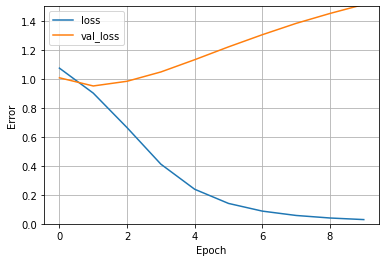

In [ ]:
plot_loss(history, 1.5)

In [ ]:
print("Linear + Task-specific embedding performance(train):", linear_model.evaluate(X_train, y_train))
print("Linear + Task-specific embedding performance(test):", linear_model.evaluate(X_test, y_test))

Linear + Task-specific embedding performance(train): [0.32066756366417, 0.89281523]
Linear + Task-specific embedding performance(test): [1.5483325862713917, 0.46444544]


In [ ]:
# dnn model
embedding_dim = 100
dnn_model = tf.keras.models.Sequential([
  tf.keras.layers.Embedding(input_dim=vocab_size, #embedding input
                           output_dim=embedding_dim,#embedding output
                           input_length=maxlen), #maximum length of an input sequence
  tf.keras.layers.GlobalAveragePooling1D(),
  tf.keras.layers.Flatten(), #flatten layer
  tf.keras.layers.Dense(16, activation='relu'),
  tf.keras.layers.Dense(3, activation=tf.nn.softmax)
])
dnn_model.compile(optimizer='adam',
              loss= "categorical_crossentropy", 
              metrics=['accuracy'])

In [ ]:
%time history = dnn_model.fit(np.array(X_train), np.array(y_train), epochs=1000, batch_size= 128, validation_split= 0.2, callbacks=[callback])

Train on 14308 samples, validate on 3577 samples
Epoch 1/1000
14308/14308 [==============================] - 1s 70us/sample - loss: 1.0831 - accuracy: 0.4430 - val_loss: 1.0617 - val_accuracy: 0.4596
Epoch 2/1000
 1152/14308 [=>............................] - ETA: 0s - loss: 1.0658 - accuracy: 0.4479

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2426: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



14308/14308 [==============================] - 1s 58us/sample - loss: 1.0642 - accuracy: 0.4511 - val_loss: 1.0572 - val_accuracy: 0.4596
Epoch 3/1000
14308/14308 [==============================] - 1s 58us/sample - loss: 1.0617 - accuracy: 0.4511 - val_loss: 1.0538 - val_accuracy: 0.4596
Epoch 4/1000
14308/14308 [==============================] - 1s 57us/sample - loss: 1.0550 - accuracy: 0.4523 - val_loss: 1.0453 - val_accuracy: 0.4641
Epoch 5/1000
14308/14308 [==============================] - 1s 56us/sample - loss: 1.0369 - accuracy: 0.4660 - val_loss: 1.0213 - val_accuracy: 0.4831
Epoch 6/1000
14308/14308 [==============================] - 1s 60us/sample - loss: 1.0039 - accuracy: 0.4898 - val_loss: 0.9934 - val_accuracy: 0.5091
Epoch 7/1000
14308/14308 [==============================] - 1s 56us/sample - loss: 0.9725 - accuracy: 0.5078 - val_loss: 0.9802 - val_accuracy: 0.5074
Epoch 8/1000
14308/14308 [==============================] - 1s 57us/sample - loss: 0.9499 - accuracy: 0.522

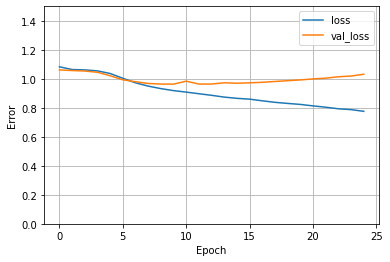

In [ ]:
plot_loss(history, 1.5)

In [ ]:
print("DNN + Task-specific embedding performance(train):", dnn_model.evaluate(X_train, y_train))
print("DNN + Task-specific embedding performance(test):", dnn_model.evaluate(X_test, y_test))

DNN + Task-specific embedding performance(train): [0.8204529013619064, 0.6145373]
DNN + Task-specific embedding performance(test): [1.0348650306623182, 0.5116279]


We see that using data-specific embeddings produces high training accuracy and low test accuracy in the linear model, indicating overfitting in this model. The dnn model decreases the training accuracy (avoid overfitting) and improves the test accuracy. However, the model still stops improving the performance on the validation dataset farily early. We want to see if using pretrained GloVe would enhance the model.

#### Pretrained GloVe

In [ ]:
#add pretrained GloVe
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2021-06-01 04:12:44--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-06-01 04:12:44--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-06-01 04:12:44--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [ ]:
# load the GloVe into embeddings_index dictionary, check number of words in the pretained model
# path_to_glove_file = os.path.join("glove.6B.100d.txt"
# )

embeddings_index = {}
with open("glove.6B.100d.txt") as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [ ]:
embeddings_index['prison'].shape #each word correspond to a 100 dimension matrix

(100,)

In [ ]:
#prepare embedding matrix
num_tokens = vocab_size +1
hits = 0
misses = 0
index_missed = [] #record index of the words that are missing in the pretrain model
embedding_dim = 100
embedding_matrix = np.zeros((num_tokens, embedding_dim))
oov = [] #record words missed in the pretrain model
for word, i in tok.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector 
        hits += 1
    else:
        oov.append(word)
        misses += 1
        index_missed.append(i)
print("Converted %d words (%d misses)" % (hits, misses))

Converted 44129 words (12878 misses)


In [ ]:
linear_model = tf.keras.models.Sequential([
  tf.keras.layers.Embedding(input_dim=num_tokens, #embedding input
                           output_dim=embedding_dim,#embedding output
                           input_length=maxlen,
                           embeddings_initializer = tf.keras.initializers.Constant(embedding_matrix)),
  tf.keras.layers.Flatten(), #flatten layer
  tf.keras.layers.Dense(3, activation=tf.nn.softmax) #ouput layer a Dense layer with 3 probabilities
])

In [ ]:
linear_model.compile(optimizer='adam',
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [ ]:
%time history = linear_model.fit(np.array(X_train), np.array(y_train), epochs=1000, batch_size= 128, validation_split= 0.2, callbacks=[callback])

Train on 14308 samples, validate on 3577 samples
Epoch 1/1000
14308/14308 [==============================] - 1s 73us/sample - loss: 1.0288 - accuracy: 0.4757 - val_loss: 1.0088 - val_accuracy: 0.5021
Epoch 2/1000
  128/14308 [..............................] - ETA: 0s - loss: 0.8863 - accuracy: 0.5625

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2426: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



14308/14308 [==============================] - 1s 57us/sample - loss: 0.8532 - accuracy: 0.6011 - val_loss: 1.0501 - val_accuracy: 0.5027
Epoch 3/1000
14308/14308 [==============================] - 1s 57us/sample - loss: 0.7494 - accuracy: 0.6728 - val_loss: 1.0686 - val_accuracy: 0.4845
Epoch 4/1000
14308/14308 [==============================] - 1s 57us/sample - loss: 0.6500 - accuracy: 0.7355 - val_loss: 1.1190 - val_accuracy: 0.4895
Epoch 5/1000
14308/14308 [==============================] - 1s 56us/sample - loss: 0.5550 - accuracy: 0.7915 - val_loss: 1.1651 - val_accuracy: 0.4783
Epoch 6/1000
14308/14308 [==============================] - 1s 57us/sample - loss: 0.4693 - accuracy: 0.8391 - val_loss: 1.2117 - val_accuracy: 0.4736
Epoch 7/1000
14308/14308 [==============================] - 1s 57us/sample - loss: 0.3892 - accuracy: 0.8801 - val_loss: 1.2702 - val_accuracy: 0.4646
Epoch 8/1000
14308/14308 [==============================] - 1s 56us/sample - loss: 0.3165 - accuracy: 0.911

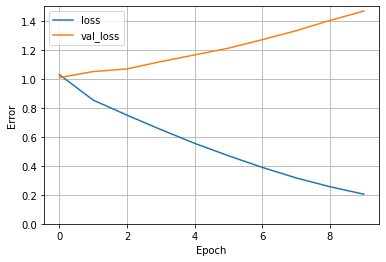

In [ ]:
plot_loss(history, 1.5)

In [ ]:
print("Linear + Pre-trained embedding performance(train):", linear_model.evaluate(X_train, y_train))
print("Linear + Pre-trained embedding performance(test):", linear_model.evaluate(X_test, y_test))

Linear + Pre-trained embedding performance(train): [0.4262109173120718, 0.8715684]
Linear + Pre-trained embedding performance(test): [1.4614741868324483, 0.44722718]


In [ ]:
# dnn model
embedding_dim = 100
dnn_model = tf.keras.models.Sequential([
  tf.keras.layers.Embedding(input_dim=num_tokens, #embedding input
                           output_dim=embedding_dim,#embedding output
                           input_length=maxlen,
                           embeddings_initializer = tf.keras.initializers.Constant(embedding_matrix)),
  tf.keras.layers.GlobalAveragePooling1D(),
  tf.keras.layers.Flatten(), #flatten layer
  tf.keras.layers.Dense(16, activation='relu'),
  tf.keras.layers.Dense(3, activation=tf.nn.softmax)
])
dnn_model.compile(optimizer='adam',
              loss= "categorical_crossentropy", 
              metrics=['accuracy'])

In [ ]:
%time history = dnn_model.fit(np.array(X_train), np.array(y_train), epochs=1000, batch_size= 128, validation_split= 0.2, callbacks=[callback])

Train on 14308 samples, validate on 3577 samples
Epoch 1/1000
14308/14308 [==============================] - 1s 75us/sample - loss: 1.0676 - accuracy: 0.4508 - val_loss: 1.0554 - val_accuracy: 0.4596
Epoch 2/1000
  128/14308 [..............................] - ETA: 1s - loss: 1.0902 - accuracy: 0.4062

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2426: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



14308/14308 [==============================] - 1s 59us/sample - loss: 1.0574 - accuracy: 0.4516 - val_loss: 1.0467 - val_accuracy: 0.4630
Epoch 3/1000
14308/14308 [==============================] - 1s 58us/sample - loss: 1.0457 - accuracy: 0.4620 - val_loss: 1.0319 - val_accuracy: 0.4741
Epoch 4/1000
14308/14308 [==============================] - 1s 59us/sample - loss: 1.0252 - accuracy: 0.4802 - val_loss: 1.0119 - val_accuracy: 0.4909
Epoch 5/1000
14308/14308 [==============================] - 1s 58us/sample - loss: 1.0010 - accuracy: 0.4955 - val_loss: 1.0032 - val_accuracy: 0.4976
Epoch 6/1000
14308/14308 [==============================] - 1s 59us/sample - loss: 0.9779 - accuracy: 0.5052 - val_loss: 0.9813 - val_accuracy: 0.5007
Epoch 7/1000
14308/14308 [==============================] - 1s 59us/sample - loss: 0.9575 - accuracy: 0.5169 - val_loss: 0.9779 - val_accuracy: 0.5164
Epoch 8/1000
14308/14308 [==============================] - 1s 57us/sample - loss: 0.9397 - accuracy: 0.530

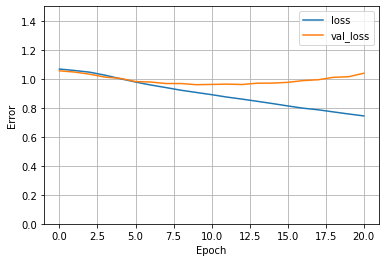

In [ ]:
plot_loss(history, 1.5)

In [ ]:
print("Pre-trained embedding performance(train):", dnn_model.evaluate(X_train, y_train))
print("Pre-trained embedding performance(test):", dnn_model.evaluate(X_test, y_test))

Pre-trained embedding performance(train): [0.7994026411269542, 0.6262231]
Pre-trained embedding performance(test): [1.046514023182004, 0.5178891]


Using pretained model performs similarly to the task-specific word embedding model. Considering there is still 12878 out of 57007 vocabulary in the dataset absent in the pretrained model. We want to fine-tune the pretrained GloVe a bit (i.e. incorporating those missing words into the embedding layer).

#### Fine-tuning GloVe

In [ ]:
np.array(index_missed).flatten()
# the index of words missed in the pretrain GloVe matrix. 
# we will use it to replace the 0s in embedding_matrix with new embedding

array([  708,  1341,  1456, ..., 56995, 56999, 57002])

In [ ]:
#get list of words not in pretrained glove
#oov = [word for word in tok.index_word.values() if word not in embeddings_index.keys()] 
cv = text.CountVectorizer(ngram_range=(1,1), vocabulary=oov)
X = cv.fit_transform(df['nonstop_str'])
Xc = (X.T * X)
Xc.setdiag(0)
coocc_ar = Xc.toarray()

/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning:

Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.



In [ ]:
# note: GPU is required for this snippet, sometimes you may also need to “Get more RAM” from colab
#use mittens library to create new_embeddings
mittens_model = mittens.Mittens(n=100, max_iter=100) #n = 100 is the embedding dimension; max_iter can be tuned
new_embeddings = mittens_model.fit(
    coocc_ar,
    vocab=oov,
    initial_embedding_dict= embeddings_index) #new embeddings matrix

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Iteration 100: loss: 6.5730671882629395

In [ ]:
new_embeddings[0]

array([ 0.04198542,  0.17414755,  0.06573907,  0.22175936,  0.00390816,
       -0.11651974, -0.25426212, -0.06206745,  0.00401954, -0.02849719,
        0.08416727, -0.22070637,  0.01738337,  0.1629418 , -0.2263735 ,
       -0.35874048, -0.08016655,  0.12708195, -0.06802733,  0.09509492,
        0.06433259,  0.00844473, -0.03410397,  0.08026312,  0.00827509,
        0.23162048,  0.10518462,  0.301787  , -0.11430746,  0.09544517,
        0.04321387,  0.05600703,  0.1278434 , -0.1939663 ,  0.15903077,
       -0.01593655, -0.19678381, -0.31615615, -0.10805786,  0.16485457,
        0.00437817, -0.06062271, -0.08083919, -0.099165  ,  0.00886148,
        0.18126406,  0.09745149,  0.13991088,  0.11267378, -0.04779567,
       -0.11341268,  0.11647624,  0.05250448, -0.01774218, -0.15388018,
       -0.03366696,  0.00350614,  0.09886356,  0.10171801,  0.04063265,
       -0.08200111,  0.00606993, -0.3693077 , -0.24553972,  0.09395641,
       -0.15503834, -0.07857637,  0.32832664,  0.24356729, -0.16

In [ ]:
for i in range(len(index_missed)):
  embedding_matrix[index_missed[i]] = new_embeddings[i]

In [ ]:
linear_model = tf.keras.models.Sequential([
  tf.keras.layers.Embedding(input_dim=num_tokens, #embedding input
                           output_dim=embedding_dim,#embedding output
                           input_length=maxlen,
                           embeddings_initializer = tf.keras.initializers.Constant(embedding_matrix)),
  tf.keras.layers.Flatten(), #flatten layer
  tf.keras.layers.Dense(3, activation=tf.nn.softmax)
])

In [ ]:
linear_model.compile(optimizer='adam',
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [ ]:
%time history = linear_model.fit(np.array(X_train), np.array(y_train), epochs=1000, batch_size= 128, validation_split= 0.2, callbacks=[callback])

Train on 14308 samples, validate on 3577 samples
Epoch 1/1000
14308/14308 [==============================] - 1s 78us/sample - loss: 1.0267 - accuracy: 0.4826 - val_loss: 1.0022 - val_accuracy: 0.5021
Epoch 2/1000
 2176/14308 [===>..........................] - ETA: 0s - loss: 0.8321 - accuracy: 0.6062

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2426: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



14308/14308 [==============================] - 1s 56us/sample - loss: 0.8518 - accuracy: 0.5994 - val_loss: 1.0369 - val_accuracy: 0.4951
Epoch 3/1000
14308/14308 [==============================] - 1s 58us/sample - loss: 0.7516 - accuracy: 0.6686 - val_loss: 1.0733 - val_accuracy: 0.4772
Epoch 4/1000
14308/14308 [==============================] - 1s 56us/sample - loss: 0.6481 - accuracy: 0.7349 - val_loss: 1.1096 - val_accuracy: 0.4870
Epoch 5/1000
14308/14308 [==============================] - 1s 56us/sample - loss: 0.5554 - accuracy: 0.7893 - val_loss: 1.1624 - val_accuracy: 0.4727
Epoch 6/1000
14308/14308 [==============================] - 1s 56us/sample - loss: 0.4672 - accuracy: 0.8402 - val_loss: 1.2185 - val_accuracy: 0.4677
Epoch 7/1000
14308/14308 [==============================] - 1s 55us/sample - loss: 0.3875 - accuracy: 0.8804 - val_loss: 1.2818 - val_accuracy: 0.4652
Epoch 8/1000
14308/14308 [==============================] - 1s 56us/sample - loss: 0.3178 - accuracy: 0.911

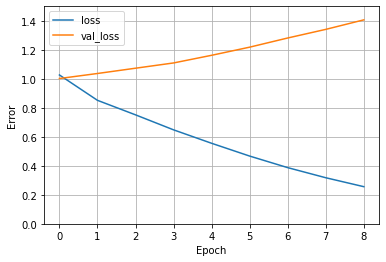

In [ ]:
plot_loss(history, 1.5)

In [ ]:
print("Linear + GLoVe with fine-tuned embedding performance(train):", linear_model.evaluate(X_train, y_train))
print("Linear + GLoVe with fine-tuned embedding performance(test):", linear_model.evaluate(X_test, y_test))

GLoVe with fine-tuned embedding performance(train): [0.4469115860808119, 0.8597708]
GLoVe with fine-tuned embedding performance(test): [1.3885025376710567, 0.46109122]


In [ ]:
# dnn model
embedding_dim = 100
dnn_model = tf.keras.models.Sequential([
  tf.keras.layers.Embedding(input_dim=num_tokens, #embedding input
                           output_dim=embedding_dim,#embedding output
                           input_length=maxlen,
                           embeddings_initializer = tf.keras.initializers.Constant(embedding_matrix)),
  tf.keras.layers.GlobalAveragePooling1D(),
  tf.keras.layers.Flatten(), #flatten layer
  tf.keras.layers.Dense(16, activation='relu'),
  tf.keras.layers.Dense(3, activation=tf.nn.softmax)
])
dnn_model.compile(optimizer='adam',
              loss= "categorical_crossentropy", 
              metrics=['accuracy'])

In [ ]:
%time history = dnn_model.fit(np.array(X_train), np.array(y_train), epochs=1000, batch_size= 128, validation_split= 0.2, callbacks=[callback])

Train on 14308 samples, validate on 3577 samples
Epoch 1/1000
14308/14308 [==============================] - 1s 66us/sample - loss: 1.0667 - accuracy: 0.4498 - val_loss: 1.0557 - val_accuracy: 0.4596
Epoch 2/1000
 2048/14308 [===>..........................] - ETA: 0s - loss: 1.0507 - accuracy: 0.4683

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2426: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



14308/14308 [==============================] - 1s 60us/sample - loss: 1.0587 - accuracy: 0.4513 - val_loss: 1.0499 - val_accuracy: 0.4604
Epoch 3/1000
14308/14308 [==============================] - 1s 59us/sample - loss: 1.0496 - accuracy: 0.4545 - val_loss: 1.0401 - val_accuracy: 0.4727
Epoch 4/1000
14308/14308 [==============================] - 1s 59us/sample - loss: 1.0334 - accuracy: 0.4677 - val_loss: 1.0173 - val_accuracy: 0.4806
Epoch 5/1000
14308/14308 [==============================] - 1s 59us/sample - loss: 1.0082 - accuracy: 0.4822 - val_loss: 0.9950 - val_accuracy: 0.4932
Epoch 6/1000
14308/14308 [==============================] - 1s 58us/sample - loss: 0.9820 - accuracy: 0.4943 - val_loss: 0.9804 - val_accuracy: 0.4957
Epoch 7/1000
14308/14308 [==============================] - 1s 59us/sample - loss: 0.9588 - accuracy: 0.5139 - val_loss: 0.9691 - val_accuracy: 0.5259
Epoch 8/1000
14308/14308 [==============================] - 1s 58us/sample - loss: 0.9410 - accuracy: 0.536

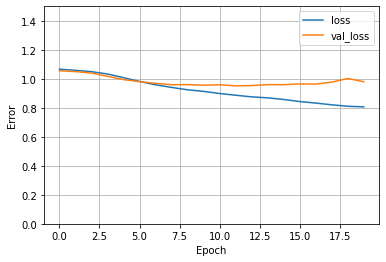

In [ ]:
plot_loss(history, 1.5)

In [ ]:
print("DNN + GLoVe with fine-tuned embedding performance(train):", dnn_model.evaluate(X_train, y_train))
print("DNN + GLoVe with fine-tuned embedding performance(test):", dnn_model.evaluate(X_test, y_test))

Pre-trained embedding performance(train): [0.8265455198048012, 0.6155997]
Pre-trained embedding performance(test): [0.982716138759538, 0.52549195]


We can see all three word embedding methods return similar prediction, therefore, we try to train a more complex model to take on the task.

## LSTM

In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Embedding(input_dim=num_tokens, #embedding input
                           output_dim=embedding_dim, #embedding output
                           input_length=maxlen,
                           embeddings_initializer = tf.keras.initializers.Constant(embedding_matrix)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim,)),
  tf.keras.layers.Dense(6, activation='relu'),
  tf.keras.layers.Flatten(), #flatten layer
  tf.keras.layers.Dense(3, activation=tf.nn.softmax)
])
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
%time history = model.fit(np.array(X_train), np.array(y_train), epochs= 20, batch_size=128, validation_split= 0.2, callbacks=[callback])

Train on 14308 samples, validate on 3577 samples
Epoch 1/20
14308/14308 [==============================] - ETA: 0s - loss: 1.0280 - accuracy: 0.4569

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2426: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



14308/14308 [==============================] - 951s 66ms/sample - loss: 1.0280 - accuracy: 0.4569 - val_loss: 0.9951 - val_accuracy: 0.4781
Epoch 2/20
14308/14308 [==============================] - 950s 66ms/sample - loss: 0.9626 - accuracy: 0.5103 - val_loss: 0.9737 - val_accuracy: 0.5152
Epoch 3/20
14308/14308 [==============================] - 985s 69ms/sample - loss: 0.9241 - accuracy: 0.5458 - val_loss: 0.9599 - val_accuracy: 0.5222
Epoch 4/20
14308/14308 [==============================] - 988s 69ms/sample - loss: 0.8818 - accuracy: 0.5789 - val_loss: 0.9814 - val_accuracy: 0.5166
Epoch 5/20
14308/14308 [==============================] - 1009s 70ms/sample - loss: 0.8344 - accuracy: 0.6081 - val_loss: 1.0028 - val_accuracy: 0.5130
Epoch 6/20
14308/14308 [==============================] - 1006s 70ms/sample - loss: 0.7776 - accuracy: 0.6433 - val_loss: 1.0695 - val_accuracy: 0.4867
Epoch 7/20
14308/14308 [==============================] - 1015s 71ms/sample - loss: 0.7077 - accuracy: 

In [ ]:
print("LSTM + GLoVe with fine-tuned embedding performance(train):", model.evaluate(X_train, y_train))
print("LSTM + GLoVe with fine-tuned embedding performance(test):", model.evaluate(X_test, y_test))

LSTM + GLoVe with fine-tuned embedding performance(train): [0.6531132736651298, 0.7490075]
LSTM + GLoVe with fine-tuned embedding performance(test): [1.351030825502331, 0.48300537]


For computational feasibility, we only train on several epochs. The model still cannot return high prediction accurarcy, which probably indicates that plot does not contain decisive information for predicting its rating.

### Combining categorical & numerical features with word embeddings

Finally, we wanted to incorporate both normal variables and textual embedding data to improve our model prediction. We follow the concept of concatenating NLP features with other features; however, the technical issue still impede us from exploring the comprehensive model. We believe we are at the final stage of the model, and with little effort we can complete it. 

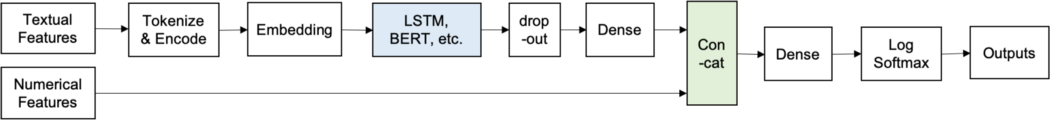

In [ ]:
df.tail()

,originalTitle,plot,startYear,runtimeMinutes,averageRating,numVotes,genres,Drama,Documentary,Action,Animation,Comedy,Biography,Thriller,Crime,Adventure,Sci-Fi,Mystery,Romance,Horror,Fantasy,Family,History,War,Music,Sport,Western,Musical,News,Reality-TV,Game-Show,plot_lower,plot_no_punctuation,averageRating_class,polarity,subjectivity,sentiment,neg,pos,neu,compound,tokenized,nonstop,stemmed,plot_sequences
22352,Falling Inn Love,When city girl Gabriela spontaneously enters a...,2019,98,5.6,9463,"['Comedy', 'Romance']",0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,when city girl gabriela spontaneously enters a...,when city girl gabriela spontaneously enters a...,1,0.345455,0.518182,positive,0.000,0.129,0.871,0.5719,"[when, city, girl, gabriela, spontaneously, en...",city girl gabriela spontaneously enters contes...,"[citi, girl, gabriela, spontan, enter, contest...","[46, 45, 1350, 2504, 2979, 3, 1043, 862, 2020,..."
22353,Chasing Happiness,A behind-the-scenes look at the life and work ...,2019,96,7.9,1398,['Documentary'],0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,a behind-the-scenes look at the life and work ...,a behindthescenes look at the life and work of...,2,0.250000,0.333333,neutral,0.000,0.000,1.000,0.0000,"[a, behindthescenes, look, at, the, life, and,...",behindthescenes look life work jonas brothers ...,"[behindthescen, look, life, work, jona, brothe...","[3235, 125, 1, 69, 4822, 228, 1292, 24, 1800, ..."
22354,VFW,A group of war veterans must defend their loca...,2019,92,7.2,74,"['Action', 'Horror']",0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,a group of war veterans must defend their loca...,a group of war veterans must defend their loca...,2,0.166667,0.233333,negative,0.132,0.122,0.746,-0.3182,"[a, group, of, war, veterans, must, defend, th...",group war veterans must defend local vfw post ...,"[group, war, veteran, must, defend, local, vfw...","[25, 59, 2222, 17, 1810, 98, 1954, 906, 746, 2..."
22355,The Pilgrim's Progress,"An epic journey, faithfully adapted to modern-...",2019,108,4.9,252,"['Adventure', 'Animation', 'Family']",0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,"an epic journey, faithfully adapted to modern-...",an epic journey faithfully adapted to modernda...,0,-0.050000,0.287500,positive,0.036,0.164,0.800,0.6428,"[an, epic, journey, faithfully, adapted, to, m...",epic journey faithfully adapted modernday chri...,"[epic, journey, faith, adapt, modernday, chris...","[615, 31, 3289, 670, 764, 489, 124, 157, 19, 4..."
22356,Manoharam,Manoharan is a poster artist struggling to fin...,2019,122,7.6,56,"['Comedy', 'Drama']",1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,manoharan is a poster artist struggling to fin...,manoharan is a poster artist struggling to fin...,2,-0.195833,0.470833,positive,0.104,0.156,0.741,0.4767,"[manoharan, is, a, poster, artist, struggling,...",manoharan poster artist struggling find respec...,"[manoharan, poster, artist, struggl, find, res...","[291, 221, 12, 2718, 1045, 183, 367, 23, 2130,..."


In [ ]:
nlp_input = tf.keras.layers.Input(shape=(maxlen), name='nlp_input')
meta_input = tf.keras.layers.Input(shape=(39,), name='meta_input')
emb = tf.keras.layers.Embedding(input_dim=num_tokens, #embedding input
                           output_dim=embedding_dim,#embedding output
                           input_length=maxlen,
                           embeddings_initializer = tf.keras.initializers.Constant(embedding_matrix))(nlp_input)
nlp_out = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, dropout=0.3, recurrent_dropout=0.3, kernel_regularizer=tf.keras.regularizers.l2(0.01)))(emb)
concact = tf.keras.layers.Concatenate()([nlp_out, meta_input])
classifier  = tf.keras.layers.Dense(64, activation='relu')(concact)
output = tf.keras.layers.Dense(3, activation=tf.nn.softmax)(classifier )
model = tf.keras.Model(inputs=[nlp_input , meta_input], outputs=[output])

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
Y = df['averageRating_class'].values
encoder = LabelEncoder()
encoder.fit(Y)
Y = encoder.transform(Y)
Y = tf.keras.utils.to_categorical(
    Y,
    num_classes=3 #equals to the number of rating categories
)

df_new = df[df.columns.difference(['originalTitle', 'plot', 'startYear', 'averageRating',
                                                         'genres', 'plot_lower', 'plot_no_punctuation', 'averageRating_class', 
                                                         'sentiment', 'neg', 'pos', 'neu', 'nonstop_str', 'tokenized', 'nonstop', 'stemmed',
                                                         'plot_sequences'])].copy()
X_train, X_test, y_train, y_test = train_test_split(df_new, Y, test_size=0.20, random_state=42)

In [ ]:
X_train_nlp = X_train['plot_padded']
X_train_meta = X_train[X_train.columns.difference(['plot_padded'])].copy()
X_test_nlp = X_test['plot_padded']
X_test_meta = X_test[X_test.columns.difference(['plot_padded'])].copy()

In [ ]:
X_train_meta

,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,Game-Show,History,Horror,Music,Musical,Mystery,News,Reality-TV,Romance,Sci-Fi,Sport,Thriller,War,Western,Year_2010,Year_2011,Year_2012,Year_2013,Year_2014,Year_2015,Year_2016,Year_2017,Year_2018,Year_2019,compound,numVotes,polarity,runtimeMinutes,subjectivity
7495,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.2263,494,0.061905,95,0.710317
15391,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,-0.6716,1791,0.316667,95,0.566667
10152,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,-0.9171,749,0.028299,133,0.532813
14608,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0.0258,45,0.100000,110,0.400000
6428,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,-0.4310,8411,-0.161111,87,0.438889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11964,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0.9565,16,0.136111,92,0.384722
21575,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,-0.6908,35,-0.200000,90,0.800000
5390,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,-0.4939,32,-0.175000,54,0.500000
860,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,-0.4404,88055,-0.034375,100,0.541667


In [ ]:
normalizer = preprocessing.Normalization(input_shape=[39,])
normalizer.adapt(np.array(X_train_meta))

In [ ]:
X_train_nlp

7495     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
15391    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
10152    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
14608    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
6428     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
                               ...                        
11964    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
21575    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
5390     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
860      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
15795    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
Name: plot_padded, Length: 17885, dtype: object

In [ ]:
np.asarray(X_train_nlp)

array([list([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [ ]:
%time model.fit([X_train_nlp.array, np.array(X_train_meta)], np.array(y_train), epochs= 1000, batch_size=128, callbacks=[callback], validation_split= 0.2)

ValueError: ignored